Names: Fabio Lenherr & Kaj Habegger

Copyright (C) 2023  Fabio Lenherr, Kaj Habegger

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.


## Install required libraries

In [ ]:
# This is simply a workaround if the pipenv is not properly loaded
! pip install tensorflow
! pip install matplotlib
! pip install scikit-learn

# Pokegpt

## Idea

Our idea was to create a classification model that will determine the pokemon type based on the image provided.
We do this with the data of the first generation to keep both the image amount and type amount limited.
We fully understand, that this model will not be 100% correct, as pokemon will not always have a type that is solely dependent on the color or body. In other words, with some pokemon the creators were a bit too creative with their interpretation of how a type should be represented.

## Notes

- There is a problem with the pokemon that we needed to solve. Our model is designed to end up with one classification, however there are many pokemon with a dual-type. For example one pokemon might have the type Water+Ground. In this case we chose the first type for the vast majority of pokemon, with a few exceptions where we found that the secondary type makes more sense.

- Some classes do not feature enough pokemon to be included for the assignment, these classes were simply removed. Pokemon featuring dual-types with a removed type will simply live on in the other class should that be included.

## Acknowledgements

- Dataset 1 [Pokemon Generation One](https://www.kaggle.com/datasets/thedagger/pokemon-generation-one?resource=download) by HarshitDwivedi, License GPL2.0
- Dataset 2 [Pokemon Images, First Generation(17000 files)](https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files) by Mikołaj Kolman, License GPL2.0
- Template for notebook [https://www.tensorflow.org/tutorials/keras/classification](Basic classification: Classify images of clothing) by François Chollet, License Apache 2.0

## -----------------------------------------------------------------------------------------------------------------------------

## Setup

### Imports

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
from sklearn.model_selection import KFold 

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Sklearn for Confusion Matrix
from sklearn.metrics import confusion_matrix

# os for environment variables
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"


print(tf.__version__)

2.10.1


### GPU Detection

In [2]:
# Check whether GPU is available for ML or not
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Set Parameters

In [3]:
train_dir = 'datasets/dataset_training/'
test_dir = 'datasets/dataset_testing/'
batch_size = 32
img_height = 64
img_width = 64
num_epochs = 40

### Define function for Confusion Matrix

In [4]:
def plt_confmatrix(y_preds, y_trues, class_names):
    conf_matrix = confusion_matrix(y_trues, y_preds, labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(conf_matrix)

    ax.xaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
    ax.set_xticklabels([''] + class_names)
    ax.set_yticklabels([''] + class_names)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()

### Load base data

In [5]:
# We split the base data into validation and testing data.
training_ds, validation_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred", # classes can be inferred from folders. We have this structured for this specifically.
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width), # Some preprocessing happening here, resizing the images
    subset="both",
    seed=24,
    validation_split=0.2
)

# Training set for kfold-cross validation. Here we want no split as we use folds as validation data.
o_training_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width), # Some preprocessing happening here, resizing the images
)

# The testing set is made of a completely different dataset, however it still features the 1.generation of pokemon
testing_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width) # Some preprocessing happening here, resizing the images
)

Found 16276 files belonging to 11 classes.
Using 13021 files for training.
Using 3255 files for validation.
Found 16276 files belonging to 11 classes.
Found 9979 files belonging to 11 classes.


### Data information and visualization

In [6]:
# Here we simply retrieve all class names that we have available
class_names = training_ds.class_names
num_classes = len(training_ds.class_names)
print(class_names)
# as shown below, some types are left out as they had too few pictures. -> Ice, Ghost, etc.

['bug', 'electric', 'fire', 'fly', 'grass', 'ground', 'normal', 'poison', 'psychic', 'rock', 'water']


### Configure the datasets for performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
o_training_ds = o_training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch.
# This will ensure the dataset does not become a bottleneck while training your model.
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

# Dataset.prefetch overlaps data preprocessing and model execution while training

### Visualization of Classes

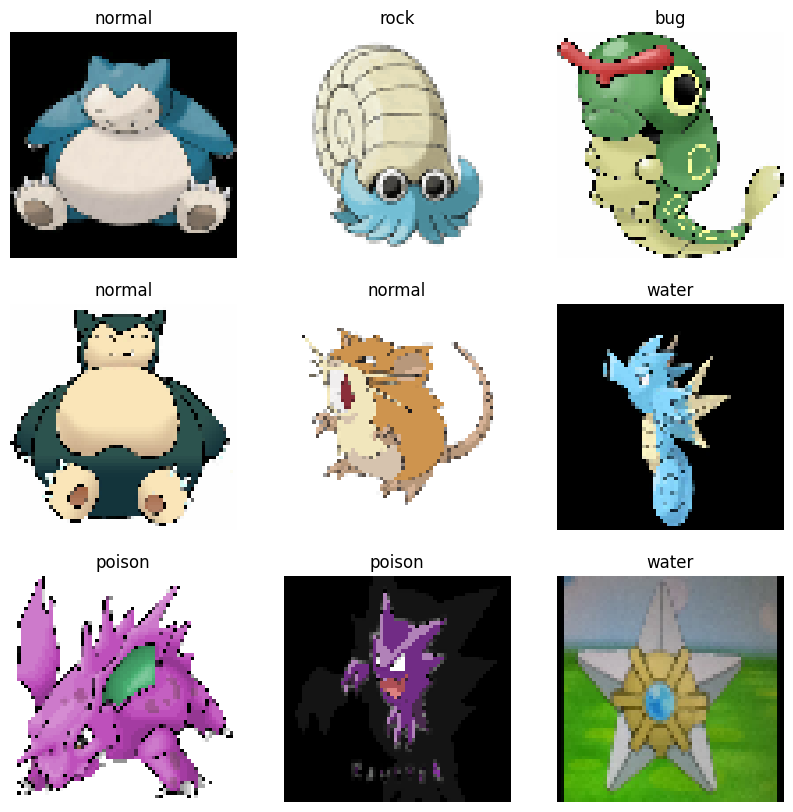

In [8]:
# Example figures for the classes.
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Visualization of Tensor

In [9]:
# Shape of each Batch
for image_batch, labels_batch in training_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 64, 64, 3)
(32,)


## -----------------------------------------------------------------------------------------------------------------------------

## Underfitted Model

The underfitted model features only a single convolutional layer, a max pooling and a dense layer at the end.
This is model is too simple to properly learn from the information provided, this means that we will end up with bad accuracy.

### Model Definition

In [10]:
underfitted_model = keras.Sequential([
    layers.Rescaling(1./63), # Some preprocessing happening here, normalizing the data
    layers.Conv2D(1, 30, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

### Model Complilation

In [11]:
underfitted_model.compile(
    optimizer='adam', # adam optimizer for better optimiztion
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['acc']
)

### Model Fitting

In [12]:
underfitted_history = underfitted_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs,
    use_multiprocessing=True
)

Epoch 1/40
407/407 [==============================] - 23s 49ms/step - loss: 2.3619 - acc: 0.2133 - val_loss: 2.3353 - val_acc: 0.2111
Epoch 2/40
407/407 [==============================] - 1s 3ms/step - loss: 2.3161 - acc: 0.2133 - val_loss: 2.3097 - val_acc: 0.2111
Epoch 3/40
407/407 [==============================] - 1s 2ms/step - loss: 2.2985 - acc: 0.2133 - val_loss: 2.3012 - val_acc: 0.2111
Epoch 4/40
407/407 [==============================] - 1s 2ms/step - loss: 2.2925 - acc: 0.2133 - val_loss: 2.2989 - val_acc: 0.2111
Epoch 5/40
407/407 [==============================] - 1s 2ms/step - loss: 2.2902 - acc: 0.2132 - val_loss: 2.2974 - val_acc: 0.2132
Epoch 6/40
407/407 [==============================] - 1s 2ms/step - loss: 2.2855 - acc: 0.2150 - val_loss: 2.2975 - val_acc: 0.2141
Epoch 7/40
407/407 [==============================] - 1s 2ms/step - loss: 2.2809 - acc: 0.2176 - val_loss: 2.2938 - val_acc: 0.2141
Epoch 8/40
407/407 [==============================] - 1s 2ms/step - loss: 

### Model Summary

In [13]:
# While the parameters are still plenty compared to the minimum requirement,
# it is important to note that we 11 classes. 
# This will result in more parameters due to the bigger dense layer.
underfitted_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 35, 35, 1)         2701      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 1)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 289)               0         
                                                                 
 dense (Dense)               (None, 11)                3190      
                                                                 
Total params: 5,891
Trainable params: 5,891
Non-trainable params: 0
______________________________________________________

### Loss and Accuracy calculation

In [14]:
# Define variables used in data visualization for the underfitted model.
acc = underfitted_history.history['acc']
val_acc = underfitted_history.history['val_acc']
loss = underfitted_history.history['loss']
val_loss = underfitted_history.history['val_loss']

### Loss

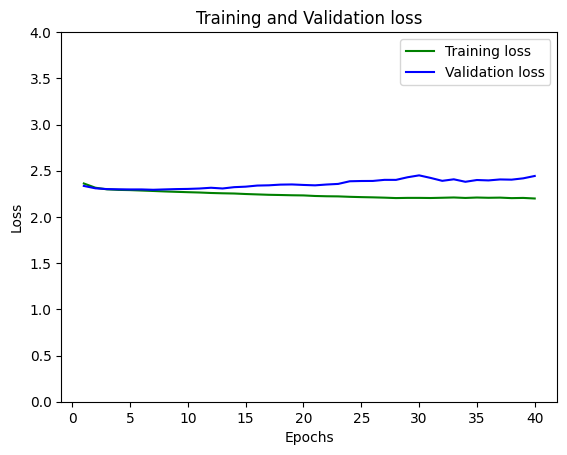

In [15]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend()
plt.show()

### Accuracy

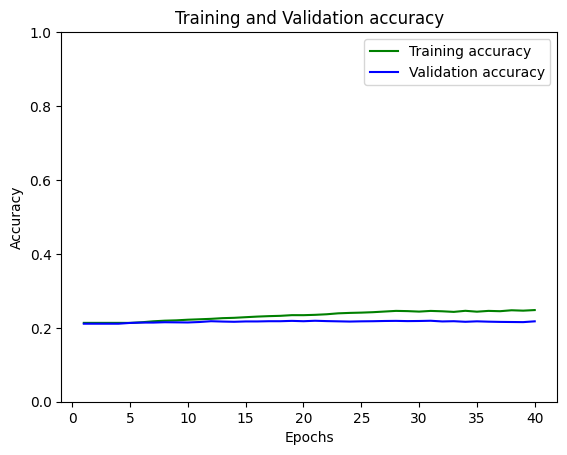

In [16]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Calculation for confusion matrix

In [17]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = underfitted_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:,0]

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 126ms/step


### Confusion Matrix

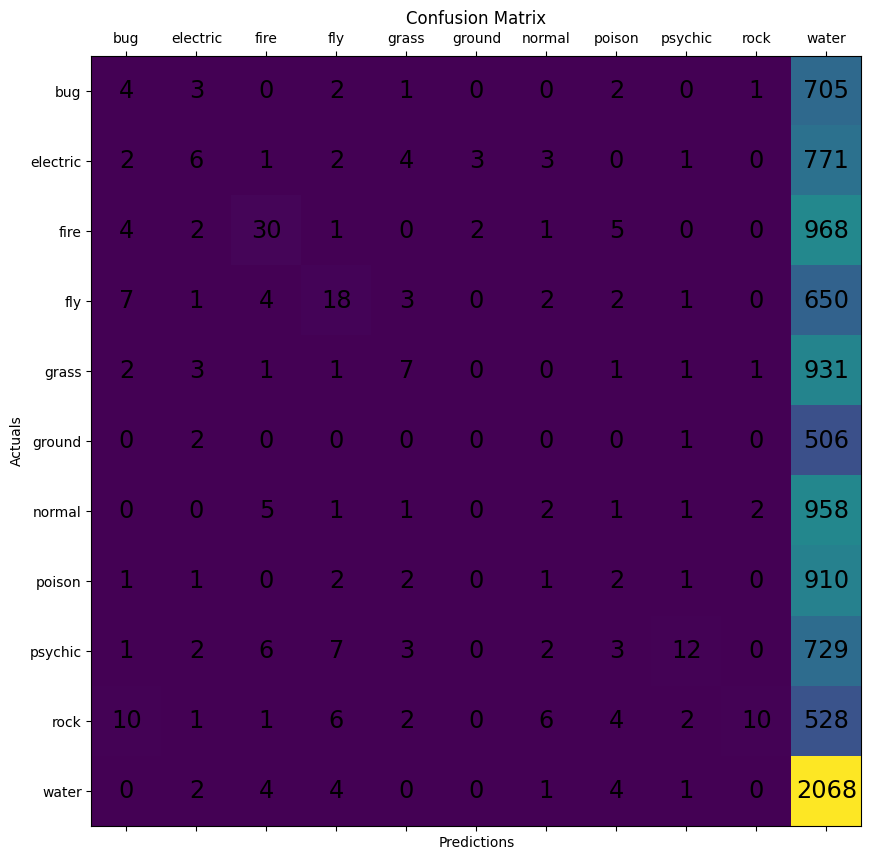

In [18]:
plt_confmatrix(y_preds, y_trues, class_names)

### Discussion
Water gets most often predicted. That's because our dataset has a higher amount of water typed pokemons. But as we can see the model is still underfitting as obviously nothing/not enough is learned from the data.

## -----------------------------------------------------------------------------------------------------------------------------

## Overfitted Model

The overfitted model will feature too many convolutional layers and dense layers, this means we will likely get a really high accuracy with our training data, but our validation/testing data will have horrible results!

### Model Definition

In [19]:
overfitted_model = keras.Sequential([
        layers.Rescaling(1./63), # Some preprocessing happening here, normalizing the data
        layers.Conv2D(64, 2, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 2, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 2, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(500),
        layers.Dense(11, activation='softmax') # Amount of neurons risen to achieve ovrfitting
])

### Model Compilation

In [20]:
overfitted_model.compile(
    optimizer='adam', 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['acc']
)

### Model Fitting

In [21]:
overfitted_history = overfitted_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs,
    use_multiprocessing=True
)

Epoch 1/40
407/407 [==============================] - 3s 5ms/step - loss: 1.8302 - acc: 0.4126 - val_loss: 1.4884 - val_acc: 0.5100
Epoch 2/40
407/407 [==============================] - 2s 5ms/step - loss: 1.2969 - acc: 0.5786 - val_loss: 1.2901 - val_acc: 0.5868
Epoch 3/40
407/407 [==============================] - 2s 5ms/step - loss: 1.0784 - acc: 0.6520 - val_loss: 1.2482 - val_acc: 0.6089
Epoch 4/40
407/407 [==============================] - 2s 5ms/step - loss: 0.9178 - acc: 0.7016 - val_loss: 1.2618 - val_acc: 0.6135
Epoch 5/40
407/407 [==============================] - 2s 5ms/step - loss: 0.7865 - acc: 0.7449 - val_loss: 1.3404 - val_acc: 0.6120
Epoch 6/40
407/407 [==============================] - 2s 5ms/step - loss: 0.7064 - acc: 0.7659 - val_loss: 1.4499 - val_acc: 0.6261
Epoch 7/40
407/407 [==============================] - 2s 5ms/step - loss: 0.6381 - acc: 0.7911 - val_loss: 1.6493 - val_acc: 0.5942
Epoch 8/40
407/407 [==============================] - 2s 5ms/step - loss: 0.

### Model Summary

In [22]:
# There is a significant increase in parameters compared to the underfitted model.
# This is expected, as this model has more convolutional and dense layers.
overfitted_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 256)      

### Loss and Accuracy calculation

In [23]:
acc = overfitted_history.history['acc']
val_acc = overfitted_history.history['val_acc']
loss = overfitted_history.history['loss']
val_loss = overfitted_history.history['val_loss']

### Loss

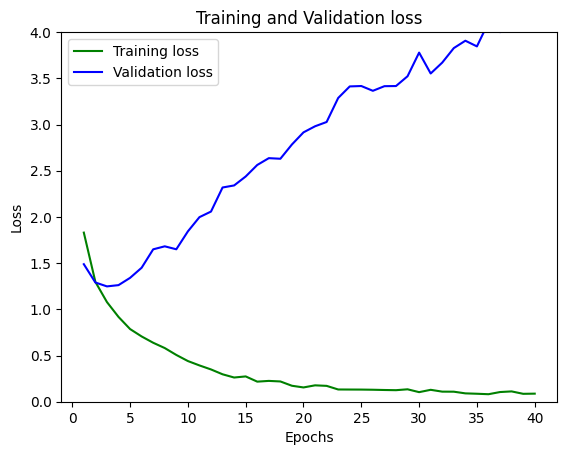

In [24]:
# Plotting training and validation loss
# As expected, the validation loss is actually increasing, while the training loss is minimalized.
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend()
plt.show()

### Accuracy

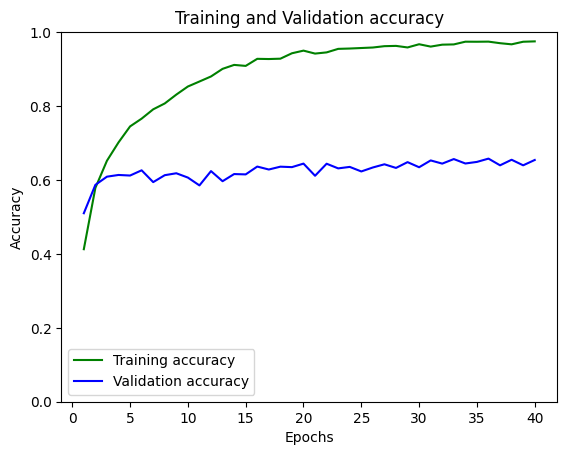

In [25]:
# Plotting training and validation accuracy
# The accurary is comparable to the loss above.
# While the training accuracy is good, the validation accuracy is horrible.
# It is important to note however, that the validation accuracy is somewhat stable, while the loss is increasing!
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Calculation for Confusion Matrix

In [26]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = overfitted_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:,0]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 198ms/step


### Confusion Matrix

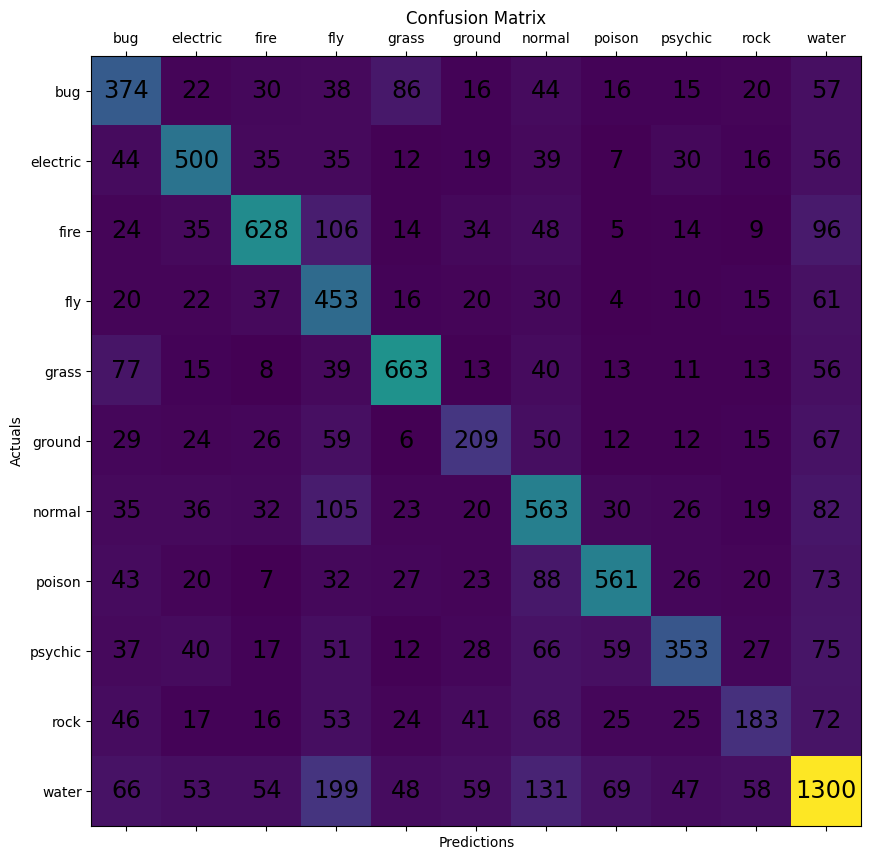

In [27]:
plt_confmatrix(y_preds, y_trues, class_names)

### Discussion

As expected, the overfitted model did well on the training data, extremely well in fact! However, the validation data never got over 0.8 accuracy and the loss increased over time. This is expected in the overfitted model.
What is however interesting, is that the confusion matrix that is based on the testing data is actually quite ok overall.

## -----------------------------------------------------------------------------------------------------------------------------

## Optimized Model

### In here we will use kfold cross validation to ensure that our model is not overffitting or underfitting, the expectation therefore is a good score in both train/validation accuracy as well as test accuracy.

### Reload data without the datasplit, as kfold cross validation takes care of this instead!

### Kfold Parameters & Regularizer

In [8]:
splits = 5
scores = [None] * splits
models = [None] * splits
regularizer = keras.regularizers.l2(0.01)

### Setup for Kfold

In [9]:
train_images = np.concatenate(list(o_training_ds.map(lambda x, y:x)))
train_labels = np.concatenate(list(o_training_ds.map(lambda x, y:y)))

test_images = np.concatenate(list(testing_ds.map(lambda x, y:x)))
test_labels = np.concatenate(list(testing_ds.map(lambda x, y:y)))

inputs = np.concatenate((train_images, test_images), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)


kfold = KFold(n_splits=splits, shuffle=True)
iteration = 0
print("kfold setup done")

kfold setup done


### KFold

In [10]:
print("Starting kfold model evaluation")
for train, test in kfold.split(inputs, targets):
    optimized_model = keras.Sequential([
        layers.Rescaling(1./63), # Some preprocessing happening here, normalizing the data
        layers.Conv2D(64, 5, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 5, activation='relu', kernel_regularizer=regularizer),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 5, activation='relu', kernel_regularizer=regularizer),
        layers.Dropout(0.5),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    print("fitting model: " + f"{iteration}")
    
    optimized_model.compile(
        optimizer='adam', 
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['acc']
    )
    
    optimized_history = optimized_model.fit(
        inputs[train],
        targets[train],
        epochs=20
    )
    
    models[iteration] = optimized_model
    
    scores[iteration] = optimized_model.evaluate(inputs[test], targets[test], verbose=0)
    iteration += 1

print(scores)

Starting kfold model evaluation
fitting model: 0
Epoch 1/20
657/657 [==============================] - 7s 7ms/step - loss: 2.2827 - acc: 0.3674
Epoch 2/20
657/657 [==============================] - 4s 6ms/step - loss: 1.6980 - acc: 0.4735
Epoch 3/20
657/657 [==============================] - 4s 6ms/step - loss: 1.5663 - acc: 0.5167
Epoch 4/20
657/657 [==============================] - 4s 6ms/step - loss: 1.4914 - acc: 0.5458
Epoch 5/20
657/657 [==============================] - 4s 6ms/step - loss: 1.4286 - acc: 0.5710
Epoch 6/20
657/657 [==============================] - 4s 6ms/step - loss: 1.3890 - acc: 0.5852
Epoch 7/20
657/657 [==============================] - 4s 6ms/step - loss: 1.3591 - acc: 0.5967
Epoch 8/20
657/657 [==============================] - 4s 7ms/step - loss: 1.3150 - acc: 0.6185
Epoch 9/20
657/657 [==============================] - 4s 6ms/step - loss: 1.2892 - acc: 0.6260
Epoch 10/20
657/657 [==============================] - 4s 6ms/step - loss: 1.2652 - acc: 0.6345


657/657 [==============================] - 4s 6ms/step - loss: 1.3967 - acc: 0.5887
Epoch 6/20
657/657 [==============================] - 4s 6ms/step - loss: 1.3480 - acc: 0.6057
Epoch 7/20
657/657 [==============================] - 4s 6ms/step - loss: 1.3222 - acc: 0.6179
Epoch 8/20
657/657 [==============================] - 4s 7ms/step - loss: 1.2983 - acc: 0.6265
Epoch 9/20
657/657 [==============================] - 4s 7ms/step - loss: 1.2786 - acc: 0.6317
Epoch 10/20
657/657 [==============================] - 4s 7ms/step - loss: 1.2559 - acc: 0.6439
Epoch 11/20
657/657 [==============================] - 4s 7ms/step - loss: 1.2445 - acc: 0.6470
Epoch 12/20
657/657 [==============================] - 4s 7ms/step - loss: 1.2187 - acc: 0.6550
Epoch 13/20
657/657 [==============================] - 4s 6ms/step - loss: 1.2065 - acc: 0.6616
Epoch 14/20
657/657 [==============================] - 4s 7ms/step - loss: 1.2029 - acc: 0.6639
Epoch 15/20
657/657 [==============================] - 4

### Retrain the best model with all data and use this as the optimized model

In [11]:
best_model_score = 0 
best_model = 0
iteration = 0

for selected_model in scores: 
    if selected_model[1] > best_model_score:
        best_model_score = selected_model[1]
        best_model = iteration 
    iteration += 1

optimized_model = models[best_model]

optimized_history = optimized_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs
)

Epoch 1/40
407/407 [==============================] - 21s 50ms/step - loss: 1.0432 - acc: 0.7236 - val_loss: 1.0897 - val_acc: 0.7309
Epoch 2/40
407/407 [==============================] - 3s 7ms/step - loss: 0.9985 - acc: 0.7341 - val_loss: 1.0678 - val_acc: 0.7422
Epoch 3/40
407/407 [==============================] - 3s 7ms/step - loss: 0.9698 - acc: 0.7405 - val_loss: 1.1001 - val_acc: 0.7247
Epoch 4/40
407/407 [==============================] - 3s 7ms/step - loss: 0.9735 - acc: 0.7416 - val_loss: 1.1088 - val_acc: 0.7174
Epoch 5/40
407/407 [==============================] - 3s 7ms/step - loss: 0.9499 - acc: 0.7516 - val_loss: 1.0673 - val_acc: 0.7324
Epoch 6/40
407/407 [==============================] - 3s 7ms/step - loss: 0.9390 - acc: 0.7585 - val_loss: 1.1420 - val_acc: 0.7103
Epoch 7/40
407/407 [==============================] - 3s 7ms/step - loss: 0.9348 - acc: 0.7604 - val_loss: 1.1092 - val_acc: 0.7315
Epoch 8/40
407/407 [==============================] - 3s 7ms/step - loss: 

### Model Summary

In [12]:
# The expectation of our optimized model is that we are between the amount of parameters of the underfitted and overfitted model.
optimized_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 60, 60, 64)        4864      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 128)       204928    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 9, 256)        

### Loss and Accuracy calculation

In [13]:
# define variables used in visualization
acc = optimized_history.history['acc']
val_acc = optimized_history.history['val_acc']
loss = optimized_history.history['loss']
val_loss = optimized_history.history['val_loss']

### Loss

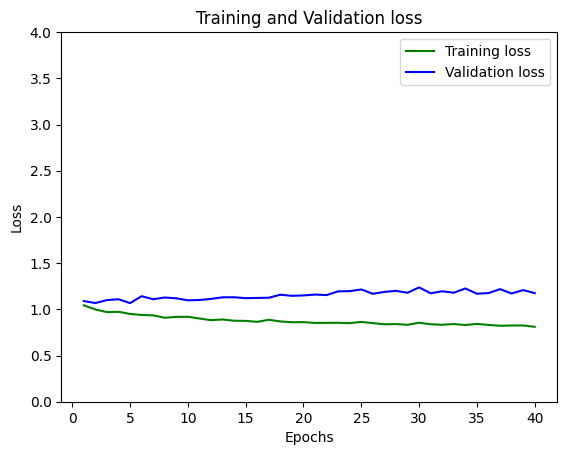

In [14]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend()
plt.show()

### Accuracy

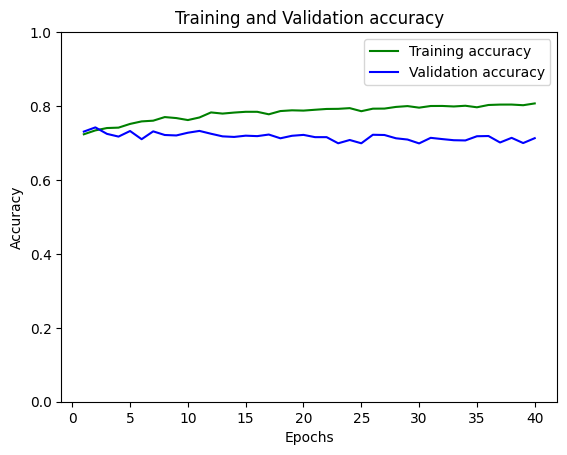

In [15]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Calculation for Confusion Matrix

In [16]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = optimized_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:,0]

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 240ms/step


### Confusion Matrix

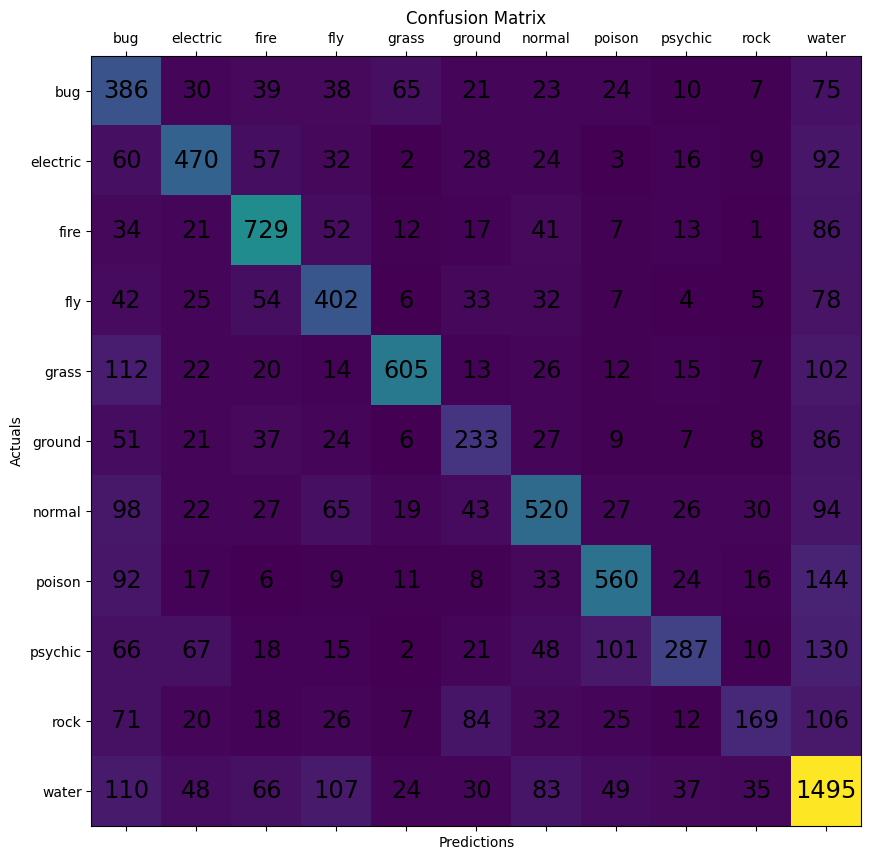

In [17]:
plt_confmatrix(y_preds, y_trues, class_names)

### Discussion

The last model is the best overall, it is slightly worse in accuracy on the training data compared to the overfitted model, but again this is expected, as we now want to focus on all possible data, this includes validation and testing data.
Depending on your usecase, meaning whether or not you will have unseen data you will want to use the overfitted model(no unseen data), or this model(unseen data exists).

## -----------------------------------------------------------------------------------------------------------------------------

## Prediction

To check the individual models simply change the name. We have left out individual predictions for each model to save space.

### Define Probability Model

In [18]:
probability_model = tf.keras.Sequential([optimized_model, 
                                         tf.keras.layers.Softmax()])

### Compile Probability Model

In [19]:
predictions = probability_model.predict(testing_ds)

312/312 [==============================] - 1s 2ms/step


### Prediction Array

In [20]:
predictions[0]

array([0.08281804, 0.08294124, 0.08248086, 0.10772046, 0.1539558 ,
       0.08224879, 0.08152633, 0.08168771, 0.0815648 , 0.08131944,
       0.08173648], dtype=float32)

### Calculatins for Prediction

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(11))
  plt.yticks([])
  thisplot = plt.bar(range(11), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


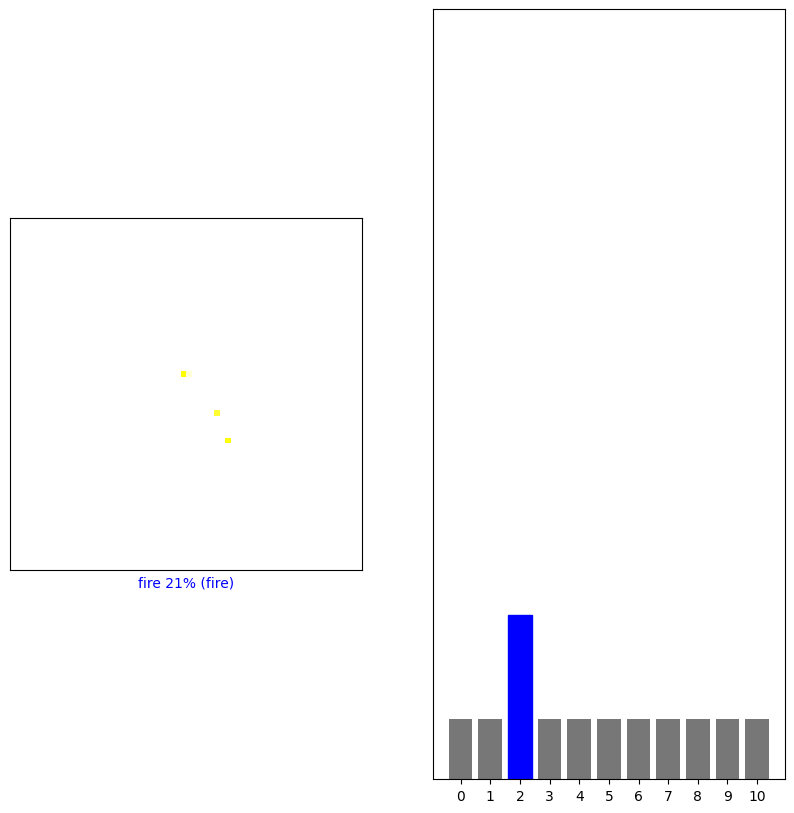

In [22]:
i = 10
ds = testing_ds

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
#for images, labels in test_ds.take(1):
iterator = iter(ds)
image, labels = next(iterator)
plot_image(i, predictions[i], labels, image)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels)
plt.show()

## -----------------------------------------------------------------------------------------------------------------------------

# Conclusion

## Comparison

### Underfitted Model

The underfitted model is a joke for our dataset. It essentially tries to play a philosopher, in this case Thales and  predicts: "everything is water".

However, there is a simple explanation for this, with the small amount of parameters the model can't specialize enough and it will default to the massive water dataset.
If the first generation of pokemon would have had a more balanced distribution for types, then we would have had a model with slightly better results, despite the low amount of parameters.

### Overfitted Model

The overfitted model is special, while the accuracy on the training set and the validation is as expected, the testing data seemed to perform rather well for an overfitted model.
One possible cause for this is that the data is still from the same generation of pokemon, which essentially means it's the "same" data, just slightly different pictures.

### Optimized Model

In terms of performance comparison it is essentially a slightly better version of the overfitted model.
This also makes sense when the model definitions are compared, the optimized model is very similar with the ridiculous 500 dense layer removed.

## Discussion

The initial expectation of the project was that the results would not be useful.
However it was quickly apparent, that even with some very vague pokemon, a model could be found that reliably
classifies pokemon of the first generation.
While the problem of more modern generations with liberal interpretations of types is would still apply to bigger models with multiple generations, it is apparent that machine learning is a very powerful tool, even in the hands of novices.

## -----------------------------------------------------------------------------------------------------------------------------